In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import tensorflow as tf
import numpy as np
from io import BytesIO
from IPython import display as idisplay
from IPython.display import display
from PIL import Image
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras import backend as K
import utils; reload(utils)
from utils import *

from matplotlib.pyplot import imshow
%matplotlib inline

Using TensorFlow backend.


In [3]:
def display_img_array(ima):
    im = Image.fromarray(ima)
    bio = BytesIO()
    im.save(bio, format='png')
    display(idisplay.Image(bio.getvalue(), format='png'))

In [4]:
# Prepare a tensor to be displayed as image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [5]:
# Size of output image
width = 200
height = 200
# DPI of monitor (for matplotlib)
dpi = 96

(200, 200, 3)

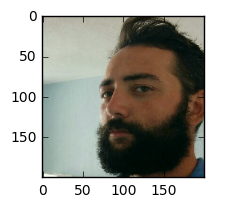

In [6]:
# Load the picture
img = Image.open('slav.jpg')
img = img.resize((width, height))
img_array = np.asarray(img.copy())

# Generate a random noise image
# img = np.random.random(size=(width, height, 3))
# img_array = (img - 0.5) * 20 + 128
plt.figure(figsize=(width/dpi, height/dpi), dpi=dpi)
imshow(img_array)
img_array.shape

In [8]:
# Load the model. Use a TF tensor as input just for fun.
K.set_learning_phase(0)
sess = tf.Session()
K.set_session(sess)

with sess.as_default():
  # Prepare tensor for input image
  image_tensor = tf.placeholder(dtype=tf.float32, shape=(1, width, height, 3))

  # Normalize input image
  #input_normalized = tf.image.per_image_standardization(image_tensor)
  # Add a batch dimension to the image (required by keras model)
  # input_batch = tf.expand_dims(input_normalized, axis=0)

In [9]:
model = VGG16(include_top=False, weights='imagenet', input_tensor=image_tensor)

In [10]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (1, 200, 200, 3)      0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (1, 200, 200, 64)     1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (1, 200, 200, 64)     36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (1, 100, 100, 64)     0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [11]:
# Get the layer to maximize (currently the last one)
output_tensor = model.get_layer('block5_conv1').output[:,:,:,:] #model.layers[-1].output
output_tensor

<tf.Tensor 'strided_slice:0' shape=(1, 12, 12, 512) dtype=float32>

In [12]:
# Calculate the gradient to excite the given neuron/layer
# Sum up the layer
excitement_score = tf.reduce_mean(output_tensor)
gradient = tf.gradients(excitement_score, image_tensor)[0]
# normalize the gradient by its L2 norm
gradient_norm = gradient / (tf.sqrt(tf.reduce_mean(tf.square(gradient))) + 1e-5)

In [13]:
# Hyperparams, so to speak
step = 10 # Strength of gradient update (learning rate)
iterations = 9 # How many times to process the image

In [14]:
input_image = img_array
original_image_mean = input_image.mean()
images = []

In [15]:
for i in range(iterations):
    # Add a batch dimension to the image
    image_batch = np.expand_dims(input_image, axis=0)
    # Compute the gradient and the loss
    gradient_computed, score = sess.run([gradient_norm, excitement_score], feed_dict={image_tensor: image_batch})
    print('Score: ', score)
    # Normalize gradient 
    gradient_computed /= gradient_computed.std()
    
    gradient_computed *= step
    # Add gradient to image to feed back into the model
    gradient_image = np.squeeze(gradient_computed)
    input_image = input_image + gradient_image
    # Keep the intermediate image to display later
    images.append(input_image)

Score:  18.4562
107.418
Score:  28.0882
107.537
Score:  49.7789
107.679
Score:  78.2994
107.831
Score:  110.047
107.978
Score:  147.26
108.134
Score:  184.772
108.279
Score:  223.034
108.423
Score:  265.771
108.565


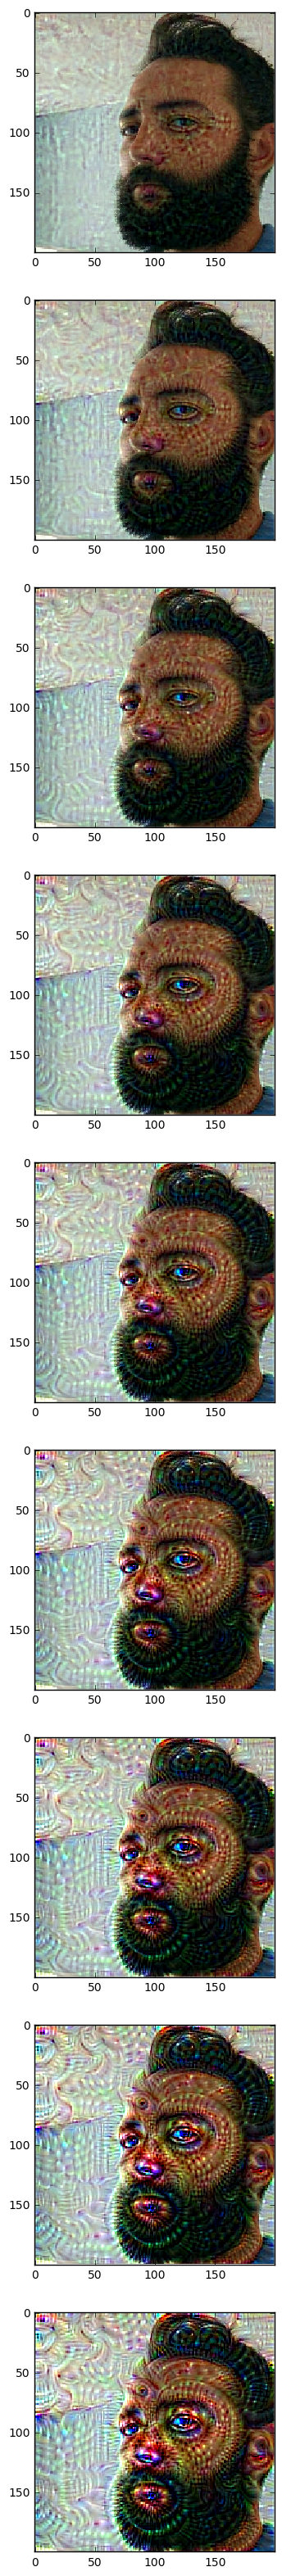

In [18]:
clipped_images = []
for index, image in enumerate(images):
    clipped_images.append(np.clip(image, 0, 255).astype('uint8'))
    #display_img_array(np.clip(image, 0, 255).astype('uint8'))
plots(clipped_images, figsize=(40,40), rows=iterations)

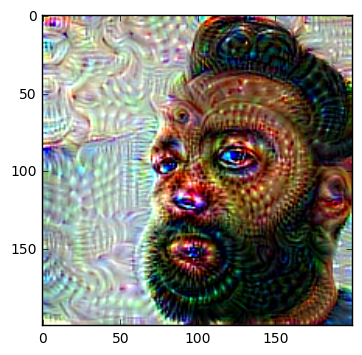

In [17]:
# Show what we got
image_to_show = np.clip(input_image, 0, 255).astype('uint8')
imshow(image_to_show)
